In [28]:
import json
from datetime import datetime
from config.default_config import Args
from agents.ppo_ import PPO
from environment.env_wrapper import EnvManager
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dictionary mapping fuel names to their mechanism files
FUEL_MECHANISMS = {
    'n-dodecane': '/home/elo/CODES/SCI-ML/RLIntegratorSelector/large_mechanism/large_mechanism/n-dodecane.yaml',
    'octane': '/home/elo/CODES/SCI-ML/RLIntegratorSelector/large_mechanism/large_mechanism/octane.yaml',
    'methane': 'gri30.yaml',
}

# Dictionary mapping fuel names to their canonical species name in the mechanism
FUEL_SPECIES = {
    'n-dodecane': 'nc12h26',
    'octane': 'IC8H18',
    'methane': 'CH4',
}

# Update fuel data paths - you should update these with your actual paths
FUEL_DATA_PATHS = {
    'n-dodecane': '/home/elo/CODES/SCI-ML/RLIntegratorSelector/ember_samples_uniform_z_n-dodecane/initial_conditions_uniform_z_n_dodecane.npz',
    # 'octane': '/home/elo/CODES/SCI-ML/RLIntegratorSelector/ember_samples_uniform_z_octane/initial_conditions_uniform_z_octane.npz',
    # 'methane': '/home/elo/CODES/SCI-ML/RLIntegratorSelector/ember_samples_uniform_z_CH4/initial_conditions_uniform_z_ch4.npz',
}

In [143]:
fuel = 'n-dodecane'
fuel_data = np.load(FUEL_DATA_PATHS[fuel])

In [144]:
import cantera as ct
def load_fuel_data(fuel_data_paths):
    """
    Load data for multiple fuels from specified paths.
    
    Args:
        fuel_data_paths: Dictionary mapping fuel names to their data paths
        
    Returns:
        Dictionary of fuel data, where each entry contains initial conditions
    """
    all_fuel_data = {}
    
    for fuel_name, data_path in fuel_data_paths.items():
        print(f"Loading data for fuel: {fuel_name} from {data_path}")
        data = np.load(data_path)
        
        # Extract arrays and reshape 1D arrays to 2D
        phis = data['phi'].reshape(-1, 1)
        # replace inf phi with 1e5
        phis = np.where(phis == np.inf, 1e5, phis)
        Ts = data['T'].reshape(-1, 1)
        Ps = data['P'].reshape(-1, 1) / ct.one_atm
        Ys = data['Y']
        
        # Include Z if available
        if 'Z' in data:
            Zs = data['Z'].reshape(-1, 1)
            initial_conditions = np.concatenate([phis, Ts, Ps, Zs, Ys], axis=1)
        else:
            initial_conditions = np.concatenate([phis, Ts, Ps, Ys], axis=1)
        
        all_fuel_data[fuel_name] = {
            'initial_conditions': initial_conditions,
            'has_Z': 'Z' in data
        }
        
        print(f"  Loaded {len(initial_conditions)} conditions for {fuel_name}")
    
    return all_fuel_data


def parse_composition(gas, X):
    """create a dictionary of species:fraction pairs from the gas species names and X."""
    species_names = gas.species_names
    composition = {}
    for i, species in enumerate(species_names):
        composition[species] = X[i]
    return composition

In [145]:
n_dodecane_data = load_fuel_data(FUEL_DATA_PATHS)

Loading data for fuel: n-dodecane from /home/elo/CODES/SCI-ML/RLIntegratorSelector/ember_samples_uniform_z_n-dodecane/initial_conditions_uniform_z_n_dodecane.npz
  Loaded 5000 conditions for n-dodecane


In [146]:
n_dodecane_data = n_dodecane_data['n-dodecane']

In [147]:
T = n_dodecane_data['initial_conditions'][:, 1]
phis = n_dodecane_data['initial_conditions'][:, 0]
pressures = n_dodecane_data['initial_conditions'][:, 2]
Zs = n_dodecane_data['initial_conditions'][:, 3]
X = n_dodecane_data['initial_conditions'][:, 4:]

print(f"X shape: {X.shape}")
print(f"T shape: {T.shape}")
print(f"phis shape: {phis.shape}")
print(f"pressures shape: {pressures.shape}")





X shape: (5000, 106)
T shape: (5000,)
phis shape: (5000,)
pressures shape: (5000,)


In [148]:
print(f"Maximum phi: {np.max(phis)}, Minimum phi: {np.min(phis)}, Mean phi: {np.mean(phis)}, Median phi: {np.median(phis)}, Standard deviation of phi: {np.std(phis)}")
print(f"Maximum T: {np.max(T)}, Minimum T: {np.min(T)}, Mean T: {np.mean(T)}, Median T: {np.median(T)}, Standard deviation of T: {np.std(T)}")
print(f"Maximum pressure: {np.max(pressures)}, Minimum pressure: {np.min(pressures)}, Mean pressure: {np.mean(pressures)}, Median pressure: {np.median(pressures)}, Standard deviation of pressure: {np.std(pressures)}")

Maximum phi: 100000.0, Minimum phi: 0.0, Mean phi: 1106.3069654287378, Median phi: 17.325535630314437, Standard deviation of phi: 9946.490405745413
Maximum T: 1596.1653084872814, Minimum T: 300.91188097167213, Mean T: 807.7188174539523, Median T: 786.8496290677715, Standard deviation of T: 288.9755592190623
Maximum pressure: 1.0, Minimum pressure: 1.0, Mean pressure: 1.0, Median pressure: 1.0, Standard deviation of pressure: 0.0


In [164]:
# how many phis are greater than 1000
print(f"Number of phis greater than 1000: {np.sum(phis > 1000) / len(phis)}")
# how many phis are greater than 10000
print(f"Number of phis greater than 10000: {np.sum(phis > 10000) / len(phis)}")
# how many phis are greater than 100000
print(f"Number of phis greater than 100000: {np.sum(phis > 100000) / len(phis)}")


Number of phis greater than 1000: 0.03
Number of phis greater than 10000: 0.01
Number of phis greater than 100000: 0.0


In [172]:
phis[-390]

np.float64(1.733448591192508)

In [149]:
def calculate_simple_phi(gas, fuel_name, oxidizer_name="O2"):
    """
    Calculate equivalence ratio for a simple hydrocarbon fuel and oxygen
    
    Args:
        gas (ct.Solution): Cantera Solution object with current state
        fuel_name (str): Name of the fuel species
        oxidizer_name (str): Name of the oxidizer species (default: "O2")
    
    Returns:
        float: Equivalence ratio phi
    """
    # Get indices
    fuel_idx = gas.species_index(fuel_name)
    oxidizer_idx = gas.species_index(oxidizer_name)
    
    # Get number of C, H, and O atoms in fuel molecule
    n_C = gas.n_atoms(fuel_idx, 'C')
    n_H = gas.n_atoms(fuel_idx, 'H')
    n_O = gas.n_atoms(fuel_idx, 'O')
    
    # Calculate the stoichiometric coefficient:
    # CxHyOz + (x + y/4 - z/2) O2 → x CO2 + (y/2) H2O
    stoich_coeff = n_C + n_H/4.0 - n_O/2.0
    
    # Get current mole fractions
    X_fuel = gas.X[fuel_idx]
    X_oxidizer = gas.X[oxidizer_idx]
    
    # Calculate phi
    phi = (X_fuel / X_oxidizer) / (1 / stoich_coeff)
    
    # Alternative formulation: phi = X_fuel/X_oxidizer * stoich_coeff
    
    return phi


def calculate_equivalence_ratio(gas, fuel_species, oxidizer_species="O2"):
    """
    Calculate the equivalence ratio phi for a given Cantera gas mixture.
    
    Args:
        gas (ct.Solution): Cantera Solution object with current state
        fuel_species (str or list): Name(s) of fuel species
        oxidizer_species (str): Name of oxidizer species (default: "O2")
    
    Returns:
        float: Equivalence ratio phi
    """
    import numpy as np
    
    # Convert fuel_species to list if it's a string
    if isinstance(fuel_species, str):
        fuel_species = [fuel_species]
        
    # Get species indices
    fuel_indices = [gas.species_index(species) for species in fuel_species]
    oxidizer_index = gas.species_index(oxidizer_species)
    
    # Get current composition
    X = gas.X
    
    # Calculate the actual fuel-to-oxidizer ratio
    X_fuel = np.sum([X[i] for i in fuel_indices])
    X_oxidizer = X[oxidizer_index]
    actual_ratio = X_fuel / X_oxidizer if X_oxidizer > 0 else float('inf')
    
    # Calculate stoichiometric coefficients for complete combustion
    # For each fuel, calculate how much oxygen is needed for complete combustion
    stoich_O2_needed = 0
    for fuel_idx in fuel_indices:
        # Get number of C, H, and O atoms in fuel molecule
        n_C = gas.n_atoms(fuel_idx, 'C')
        n_H = gas.n_atoms(fuel_idx, 'H')
        n_O = gas.n_atoms(fuel_idx, 'O')
        
        # Calculate O2 needed for this fuel:
        # CxHyOz + (x + y/4 - z/2) O2 → x CO2 + (y/2) H2O
        stoich_coeff = n_C + n_H/4.0 - n_O/2.0
        stoich_O2_needed += stoich_coeff * X[fuel_idx]
    
    # Calculate stoichiometric ratio (fuel to oxidizer)
    stoich_ratio = X_fuel / stoich_O2_needed if stoich_O2_needed > 0 else float('inf')
    
    # Calculate equivalence ratio
    phi = actual_ratio / stoich_ratio if stoich_ratio > 0 else float('inf')
    
    return phi


In [161]:
gas = ct.Solution(FUEL_MECHANISMS[fuel])


index = np.random.randint(0, len(T))
print(f"Index: {index}")
# X = parse_composition(gas, X)

species_to_track = ['o2',  FUEL_SPECIES[fuel]]

o2_index = gas.species_index('o2')
h2_index = gas.species_index('h2')
h2o_index = gas.species_index('h2o')
co2_index = gas.species_index('co2')
co_index = gas.species_index('co')
fuel_index = gas.species_index(FUEL_SPECIES[fuel])

print(f"fuel_index: {fuel_index}, o2_index: {o2_index}")
gas.TPY = T[index], pressures[index], X[index]

print(f"Gas temperature: {gas.T}")
print(f"Gas pressure: {gas.P}")
for species in species_to_track:
    print(f"{species}: {gas.X[gas.species_index(species)]}")

print(f"Z: {Zs[index]}")

print(f"Original phi: {phis[index]}")



phi_calculated = calculate_simple_phi(gas, FUEL_SPECIES[fuel], 'o2')
print(f"Calculated phi: {phi_calculated}")

phi_calculated2 = calculate_equivalence_ratio(gas, FUEL_SPECIES[fuel], 'o2')
print(f"Calculated phi 2: {phi_calculated2}")


print(gas.equivalence_ratio())





Index: 485
fuel_index: 66, o2_index: 3
Gas temperature: 459.2243517427133
Gas pressure: 0.9999999999999999
o2: 0.10357460871568366
nc12h26: 0.5069848625133456
Z: 0.8585858585858587
Original phi: 97.43029724508227
Calculated phi: 90.5552053036784
Calculated phi 2: 90.5552053036784
90.55520530367842


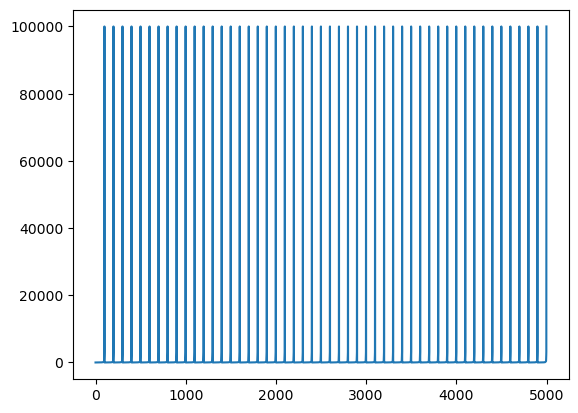

In [162]:
#plot all equivalence ratios
fig = plt.figure()
plt.plot(phis)
plt.show()






In [140]:
gas.equivalence_ratio()

2.0572379298198733

In [175]:
np.log10(1.6758398866510207)/3

np.float64(0.07474417428232198)

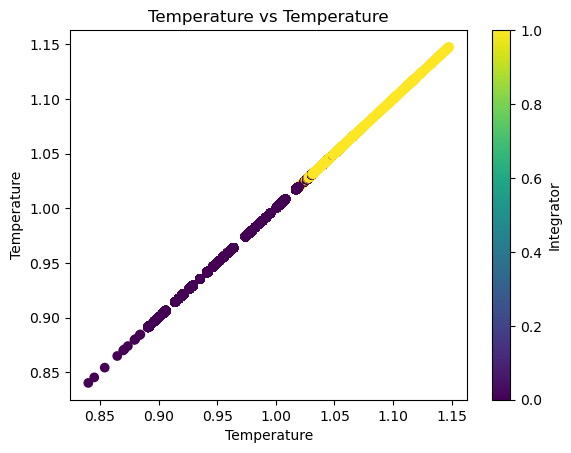

In [26]:
# plot all the temperature in a scatter plot
plt.scatter(obs[:, 0], obs[:, 0], c=action, cmap='viridis')
plt.colorbar(label='Integrator')
plt.xlabel('Temperature')
plt.ylabel('Temperature')
plt.title('Temperature vs Temperature')
plt.show()

In [23]:
phi = obs[:, 1]

In [24]:
print(f"Maximum phi: {np.max(phi)}")
print(f"Minimum phi: {np.min(phi)}")
print(f"Mean phi: {np.mean(phi)}")
print(f"Median phi: {np.median(phi)}")
print(f"Standard deviation of phi: {np.std(phi)}")



Maximum phi: 1.1851686239242554
Minimum phi: -1.0
Mean phi: 0.31104526142883077
Median phi: 0.29873692989349365
Standard deviation of phi: 0.20789069839556873


In [6]:
phi = np.maximum(phi, 1e-3)
phi = np.minimum(phi, 1e4)
data[:, 1] = np.log10(phi)/3

In [4]:
# save data
import os
import numpy as np


data = np.load('/home/elo/CODES/SCI-ML/0D_integratorRL/pretraining_results/20250408_171422/data/pretraining_dataset.npy')


In [5]:
data.shape

(48302, 17)

In [8]:
env_args = Args()
env_args.timeout = 0.5
env_manager = EnvManager(env_args, create_envs=False)

fixed_temperature = 1200
fixed_pressure = 1
fixed_phi = 0.76
end_time = 0.1
fixed_dt = 0.0001

In [9]:
# Create a sample environment to get dimensions

env = env_manager.create_single_env(
    end_time=end_time,
    fixed_temperature=fixed_temperature,
    fixed_pressure=fixed_pressure,
    fixed_phi=fixed_phi,
    randomize=False,
    fixed_dt=fixed_dt
)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

envs = {}
for i in range(action_dim):
    envs[i] = env_manager.create_single_env(
        end_time=end_time,
        fixed_temperature=fixed_temperature,
        fixed_pressure=fixed_pressure,
        fixed_phi=fixed_phi,
        randomize=False,
        fixed_dt=fixed_dt
    )

# Initialize PPO agent
agent = PPO(
    state_dim=state_dim,
    action_dim=action_dim,
    lr_actor=env_args.learning_rate,
    lr_critic=env_args.learning_rate,
    gamma=0.99,
    K_epochs=10,
    eps_clip=0.2,
    has_continuous_action_space=False
)

# Set up device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Creating a single environment with fixed parameters - T=1200, P=1, phi=0.76, dt=0.0001
Combustion problem initialized with T=1200, P=101325.0, phi=0.76 and timestep=0.0001


Computing reference solution: 100%|██████████| 1000/1000 [00:00<00:00, 7486.62it/s]


Reference solution computed in 0.14 seconds
Done setting up problem
Creating a single environment with fixed parameters - T=1200, P=1, phi=0.76, dt=0.0001
Combustion problem initialized with T=1200, P=101325.0, phi=0.76 and timestep=0.0001


Computing reference solution: 100%|██████████| 1000/1000 [00:00<00:00, 6840.19it/s]


Reference solution computed in 0.15 seconds
Done setting up problem
Creating a single environment with fixed parameters - T=1200, P=1, phi=0.76, dt=0.0001
Combustion problem initialized with T=1200, P=101325.0, phi=0.76 and timestep=0.0001


Computing reference solution: 100%|██████████| 1000/1000 [00:00<00:00, 7435.22it/s]

Reference solution computed in 0.14 seconds
Done setting up problem


In [10]:
obs, info = env.reset()

obs.shape





(9,)

In [11]:
obs

array([ 1.0263938 ,  0.76      , -1.        , -0.03403139, -1.        ,
       -1.        , -1.        , -1.        , -1.        ], dtype=float32)